In [1]:
#Question 1
#import
import pandas as pd
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
#from sklearn.externals import joblib
from matplotlib import pyplot as plt
import seaborn as sns
import joblib

%matplotlib inline

In [2]:
%pwd

'C:\\Users\\Iris'

In [3]:
my_path = 'C:\\Users\\Iris'

In [4]:
#Read the data
my_df = pd.read_csv(f'{my_path}/Titanic_full.csv')
print(my_df.shape)
my_df.head(3)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
#Calculate 15% of 1309. This is about 209 rows of data. 
#So, 1309 - 209 = 1100 rows of data will remain for the
#train and valid sets which we will separate later. 200 rows of data will
#go as test set data

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


mydf_train_valid,mydf_test = mydf_splitter(my_df,1100)

print(mydf_train_valid.shape,mydf_test.shape)

(1100, 12) (209, 12)


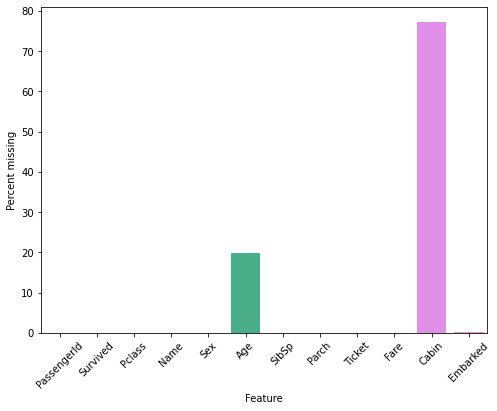

In [6]:
#Figure out which column has missing values
null_vals = mydf_train_valid.isnull().sum()/len(mydf_train_valid)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [7]:
#Drop the cabin column
mydf_train_valid_2 = mydf_train_valid.drop("Cabin",axis = 1)
print(mydf_train_valid_2.shape)
mydf_train_valid_2.head(2)

(1100, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C


In [8]:
mydf_train_valid_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1100 non-null   int64  
 1   Survived     1100 non-null   int64  
 2   Pclass       1100 non-null   int64  
 3   Name         1100 non-null   object 
 4   Sex          1100 non-null   object 
 5   Age          881 non-null    float64
 6   SibSp        1100 non-null   int64  
 7   Parch        1100 non-null   int64  
 8   Ticket       1100 non-null   object 
 9   Fare         1099 non-null   float64
 10  Embarked     1098 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 94.7+ KB


In [9]:
#1 (a) Define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [10]:
mydf_train_valid_3 = str_to_cat(mydf_train_valid_2)
mydf_train_valid_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1100 non-null   int64   
 1   Survived     1100 non-null   int64   
 2   Pclass       1100 non-null   int64   
 3   Name         1100 non-null   category
 4   Sex          1100 non-null   category
 5   Age          881 non-null    float64 
 6   SibSp        1100 non-null   int64   
 7   Parch        1100 non-null   int64   
 8   Ticket       1100 non-null   category
 9   Fare         1099 non-null   float64 
 10  Embarked     1098 non-null   category
dtypes: category(4), float64(2), int64(5)
memory usage: 161.8 KB


In [11]:
def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [12]:
mydf_train_valid_4,my_table = mydf_preprocessor(mydf_train_valid_3,null_table = None)
mydf_train_valid_4.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
0,1,0,3,135,2,22.0,1,0,629,7.2500,3,False,False
1,2,1,1,245,1,38.0,1,0,713,71.2833,1,False,False
2,3,1,3,442,1,26.0,0,0,799,7.9250,3,False,False


In [13]:
Y = mydf_train_valid_4["Survived"]
X = mydf_train_valid_4.drop(["Survived"],axis = 1)

print(X.shape,Y.shape)

(1100, 12) (1100,)


In [14]:
X_cat = X[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked', 'Age_na', 'Fare_na']]
X_con = X.drop(X_cat,axis = 1)
print(X_cat.shape,X_con.shape)

(1100, 10) (1100, 2)


In [15]:
scaler = preprocessing.StandardScaler().fit(X_con)
X_con_sc = pd.DataFrame(scaler.transform(X_con))
X_con_sc.columns = ["Age","Fare"]
print(X_con_sc.shape)
X_con_sc.head(2)

(1100, 2)


,Age,Fare
0,-0.574896,-0.502155
1,0.659705,0.747957


In [16]:
df_list = [X_cat,X_con_sc]
X_full = pd.concat(df_list,axis = 1)
print(X_full.shape)
X_full.head(2)

(1100, 12)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1,3,135,2,1,0,629,3,False,False,-0.574896,-0.502155
1,2,1,245,1,1,0,713,1,False,False,0.659705,0.747957


In [17]:
X_train,X_valid = mydf_splitter(X_full,900)
Y_train,Y_valid = mydf_splitter(Y,900)

print(X_train.shape,X_valid.shape,Y_train.shape,Y_valid.shape)

(900, 12) (200, 12) (900,) (200,)


In [18]:
my_knn_model = KNeighborsClassifier(n_neighbors = 5,weights = 'uniform')
my_knn_model.fit(X_train,Y_train)

#Predict on the validation set
Y_pred = my_knn_model.predict(X_valid)
Best_pred=5
Best_accuracy=accuracy_score(Y_valid,Y_pred)
print(Best_pred,Best_accuracy)

5 0.54


In [19]:
#Simultaneously tune the values of K, because the test set is 900 and I want the k to be 180 for the maximum value of k.
#Using for loop to find the most accurated k.
from sklearn.metrics import accuracy_score

num_neighs = list()
accuracy_list = list()

for i in range(0,9):
    for neighbor in range(1*i,20*i):
        my_knn_model = KNeighborsClassifier(n_neighbors = neighbor,weights = 'uniform')
        my_knn_model.fit(X_train,Y_train)
        Y_pred = my_knn_model.predict(X_valid)
        accuracy = accuracy_score(Y_valid,Y_pred)
        if accuracy > Best_accuracy:
            Best_accuracy=accuracy
            Best_pred=neighbor
        num_neighs.append(neighbor)
        accuracy_list.append(accuracy)

In [20]:
#There for the most accurated prediction is when k=70 where the accuracy is 0.67
eval_df =  pd.DataFrame({"Num of neighbors": num_neighs,"Valid accuracy Score": accuracy_list})
print(eval_df)
print(Best_pred,Best_accuracy)

     Num of neighbors  Valid accuracy Score
0                   1                 0.500
1                   2                 0.580
2                   3                 0.495
3                   4                 0.565
4                   5                 0.540
..                ...                   ...
679               155                 0.660
680               156                 0.660
681               157                 0.660
682               158                 0.660
683               159                 0.660

[684 rows x 2 columns]
70 0.67


In [21]:
#I want to change the values of weight which between uniform and distance to see whether the accuracy can goes up

my_knn_model_w = KNeighborsClassifier(n_neighbors = 5,weights = 'uniform')
my_knn_model_w.fit(X_train,Y_train)
Y_pred_w = my_knn_model_w.predict(X_valid)
best_w='uniform'
best_pred_w=5
best_accuracy_w=accuracy_score(Y_valid,Y_pred_w)

num_neighs_w = list()
accuracy_list_w = list()
weight_list=['uniform','distance']

for weight in weight_list:
    for neighbor in range(1,71):
        my_knn_model_w = KNeighborsClassifier(n_neighbors = neighbor,weights = weight)
        my_knn_model_w.fit(X_train,Y_train)
        Y_pred_w = my_knn_model_w.predict(X_valid)
        accuracy = accuracy_score(Y_valid,Y_pred_w)
        if accuracy > best_accuracy_w:
            best_accuracy_w=accuracy
            best_pred_w=neighbor
            best_w=weight
        num_neighs_w.append(neighbor)
        accuracy_list_w.append(accuracy)

In [22]:
# As we can see if we change the weight and the k at the same time, the best k we get is 70 and the weight is uniform.
print(best_accuracy_w,best_pred_w,best_w)

0.67 70 uniform


In [23]:
#Using gridserchcv to calculate the best k, and the accuracy we get is 0.625
from sklearn.model_selection import GridSearchCV

grid_params={
    'n_neighbors':[18,70,140,180],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}

gs=GridSearchCV(KNeighborsClassifier(),grid_params)

gs_results=gs.fit(X_train,Y_train)
Y_pred_gs=gs_results.predict(X_valid)
accuracy_gs=accuracy_score(Y_valid,Y_pred_gs)

print(accuracy_gs)


0.625


In [24]:
#save the model
import joblib 

#knn_model_fin = KNeighborsClassifier(n_neighbors = best_pred_w,weights = best_w)
#knn_model_fin.fit(X_full,Y)

#Now I am going to use the k we get from gridsearch as my k
knn_model_fin=gs.fit(X_full,Y)

!mkdir knn_model
knn_model_name = f'{my_path}/knn_model/knn_model_final.sav'
joblib.dump(knn_model_fin,knn_model_name)

['C:\\Users\\Iris/knn_model/knn_model_final.sav']

In [25]:
#get rid of the "cabin" column as we did before with the train_valid set
mydf_test1 = mydf_test.drop("Cabin",axis = 1)
print(mydf_test1.shape)
mydf_test1.head(3)

(209, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
1100,1101,1,3,"Delalic, Mr. Redjo",male,25.0,0,0,349250,7.8958,S
1101,1102,0,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,S
1102,1103,1,3,"Finoli, Mr. Luigi",male,NaN,0,0,SOTON/O.Q. 3101308,7.0500,S


In [26]:
mydf_test2 = str_to_cat(mydf_test1)
mydf_test2.Sex.cat.categories



Index(['female', 'male'], dtype='object')

In [27]:
mydf_test2.Embarked.cat.categories

Index(['C', 'Q', 'S'], dtype='object')

In [28]:
mydf_test3,my_table1 = mydf_preprocessor(mydf_test2,
                                         null_table = my_table)
print(mydf_test3.shape)
mydf_test3.head(3)

(209, 13)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
1100,1101,1,3,47,2,25.0,0,0,106,7.8958,3,False,False
1101,1102,0,3,6,2,32.0,0,0,146,22.5250,3,False,False
1102,1103,1,3,62,2,28.0,0,0,187,7.0500,3,True,False


In [29]:
my_table1

{'Age': 28.0, 'Fare': 14.4583}

In [30]:
Y_t = mydf_test3["Survived"]
X_t = mydf_test3.drop(["Survived"],axis = 1)

print(X_t.shape,Y_t.shape)

(209, 12) (209,)


In [31]:
X_cat_t = X_t[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked', 'Age_na', 'Fare_na']]
X_con_t = X_t.drop(X_cat_t,axis = 1)
print(X_cat_t.shape,X_con_t.shape)

(209, 10) (209, 2)


In [32]:
X_con_sct = pd.DataFrame(scaler.transform(X_con_t))
X_con_sct.columns = ["Age","Fare"]
print(X_con_sct.shape)
X_con_sct.head(2)

(209, 2)


,Age,Fare
0,-0.343408,-0.489547
1,0.196729,-0.203944


In [33]:
print(X_cat_t.shape,X_con_sct.shape)

(209, 10) (209, 2)


In [34]:
#Re-index before merging
X_cat_t.reset_index(inplace = True,drop = False)

In [35]:
X_cat_t.head()

,index,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na
0,1100,1101,3,47,2,0,0,106,3,False,False
1,1101,1102,3,6,2,0,0,146,3,False,False
2,1102,1103,3,62,2,0,0,187,3,True,False
3,1103,1104,2,45,2,0,0,179,3,False,False
4,1104,1105,2,91,1,1,0,38,3,False,False


In [36]:
X_cat_t.drop("index",inplace = True,axis = 1)
X_cat_t.head(2)

C:\Users\Iris\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na
0,1101,3,47,2,0,0,106,3,False,False
1,1102,3,6,2,0,0,146,3,False,False


In [37]:
#Merge the two sets of columns
df_list_I = [X_cat_t,X_con_sct]
X_test_I = pd.concat(df_list_I,axis = 1)
print(X_test_I.shape)
X_test_I.head(2)

(209, 12)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1101,3,47,2,0,0,106,3,False,False,-0.343408,-0.489547
1,1102,3,6,2,0,0,146,3,False,False,0.196729,-0.203944


In [38]:
#Now we are ready to test it out. Let's load the saved model first.
kNN_loaded = joblib.load(f'{my_path}/knn_model/knn_model_final.sav')

In [39]:
#Testing...
Y_test_pred = kNN_loaded.predict(X_test_I)

In [40]:
print(accuracy_score(Y_t,Y_test_pred),
      matthews_corrcoef(Y_t,Y_test_pred),f1_score(Y_t,Y_test_pred))

0.5645933014354066 0.0 0.0


C:\Users\Iris\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [41]:
'''Write out full train_valid and test dataframes for later use
in module III'''
X_full["Survived"] = Y
X_test_I["Survived"] = Y_t

print(X_full.shape)
print(X_test_I.shape)

(1100, 13)
(209, 13)


In [42]:
#Question 2
'''In my opinion, I think the disadvantages of k-NN algorithm is taking time to find out the correct K. 
As I using the for loops and the grid search to get the correct k, 
I figure out that as the scale of the dataset grow, the length of the loop is growing as well.
Also, even if we find the k that has the highest accuracy of the prediction of the valid dataset, 
that k may not give the highest accuracy of the prediction of the test dataset. 
I think the one of disadvantages of K-NN algorithm is taking time to find out the correct k, especially, when we have a large dataset.
Another disadvantages of K-NN algorith is that even if we find the best accurated k for the valid dataset, that k may not be the best accurated k for the test set.
'''

'In my opinion, I think the disadvantages of k-NN algorithm is taking time to find out the correct K. \nAs I using the for loops and the grid search to get the correct k, \nI figure out that as the scale of the dataset grow, the length of the loop is growing as well.\nAlso, even if we find the k that has the highest accuracy of the prediction of the valid dataset, \nthat k may not give the highest accuracy of the prediction of the test dataset. \nI think the one of disadvantages of K-NN algorithm is taking time to find out the correct k, especially, when we have a large dataset.\nAnother disadvantages of K-NN algorith is that even if we find the best accurated k for the valid dataset, that k may not be the best accurated k for the test set.\n'